In [ ]:
!python -m pip install pykalman

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 248.5/248.5 kB 5.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 145.5/145.5 kB 12.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pykalman import KalmanFilter
from sklearn.impute import KNNImputer
import time as time
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def zero_imputation(univariate_data_train,univariate_data_test):
    train_univariate_data_imputed = np.nan_to_num(univariate_data_train, nan=0)
    test_univariate_data_imputed=np.nan_to_num(univariate_data_test, nan=0)
    return train_univariate_data_imputed,test_univariate_data_imputed

def mean_imputation(univariate_data_train,univariate_data_test):
    mean_value = np.nanmean(univariate_data_train)  # NaN deƒüerleri hari√ß ortalama hesapla
    train_univariate_data_imputed = np.where(np.isnan(univariate_data_train), mean_value, univariate_data_train)
    test_univariate_data_imputed= np.where(np.isnan(univariate_data_test), mean_value, univariate_data_test)
    return train_univariate_data_imputed,test_univariate_data_imputed

def random_imputation(univariate_data_train,univariate_data_test):
    valid_values = univariate_data_train[~np.isnan(univariate_data_train)]  # NaN olmayan deƒüerleri se√ß
    if len(valid_values) == 0:
        return univariate_data_train  # Eƒüer t√ºm deƒüerler NaN ise deƒüi≈ütirme
    random_values = np.random.choice(valid_values, size=np.isnan(univariate_data_train).sum())  # Rastgele deƒüerler se√ß
    train_univariate_data_imputed = np.copy(univariate_data_train)
    train_univariate_data_imputed[np.isnan(univariate_data_train)] = random_values

    test_univariate_data_imputed=np.copy(univariate_data_test)
    valid_values_test = univariate_data_test[~np.isnan(univariate_data_test)]  # NaN olmayan deƒüerleri se√ß
    mask_test = np.isnan(test_univariate_data_imputed)
    if len(valid_values_test) == 0:
        return univariate_data_test  # Eƒüer t√ºm deƒüerler NaN ise deƒüi≈ütirme
    random_values_test = np.random.choice(valid_values, size=np.isnan(univariate_data_test).sum())  # trainden Rastgele deƒüerler se√ß

    test_univariate_data_imputed[mask_test] = np.random.choice(valid_values, size=mask_test.sum(), replace=True)

    return train_univariate_data_imputed,test_univariate_data_imputed

def median_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array i√ßindeki NaN (eksik) deƒüerleri medyan (median) ile doldurur.
    """
    median_value = np.nanmedian(univariate_data_train)  # NaN deƒüerleri hari√ß medyan hesapla
    train_univariate_data_imputed = np.where(np.isnan(univariate_data_train), median_value, univariate_data_train)
     # NaN olanlarƒ± medyan ile deƒüi≈ütir
    test_univariate_data_imputed= np.where(np.isnan(univariate_data_test), median_value, univariate_data_test) #trainin mediani ile doldur
    return train_univariate_data_imputed,test_univariate_data_imputed

def forward_fill_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array i√ßindeki NaN (eksik) deƒüerleri kendinden √∂nce gelen ilk bilinen deƒüerle doldurur.
    Eƒüer ilk deƒüerler de NaN ise, dizideki ilk bilinen deƒüeri alƒ±p doldurur.
    """
    train_univariate_data_imputed = np.copy(univariate_data_train)
    mask = np.isnan(train_univariate_data_imputed)

    # Ardƒ±≈üƒ±k NaN'leri forward fill ile doldur
    for i in range(1, len(train_univariate_data_imputed)):
        if mask[i]:
            train_univariate_data_imputed[i] = train_univariate_data_imputed[i - 1]  # √ñnceki bilinen deƒüeri ata

    # Eƒüer hala NaN kalan deƒüerler varsa, bunlarƒ± ilk bilinen deƒüer ile doldur
    first_valid_idx = np.where(~mask)[0][0] if np.any(~mask) else None
    if first_valid_idx is not None:
        train_univariate_data_imputed[np.isnan(train_univariate_data_imputed)] = train_univariate_data_imputed[first_valid_idx]

    test_univariate_data_imputed = np.copy(univariate_data_test)
    mask = np.isnan(test_univariate_data_imputed)

    # Ardƒ±≈üƒ±k NaN'leri forward fill ile doldur
    for i in range(1, len(test_univariate_data_imputed)):
        if mask[i]:
            test_univariate_data_imputed[i] = test_univariate_data_imputed[i - 1]  # √ñnceki bilinen deƒüeri ata

    # Eƒüer hala NaN kalan deƒüerler varsa, bunlarƒ± ilk bilinen deƒüer ile doldur
    first_valid_idx = np.where(~mask)[0][0] if np.any(~mask) else None
    if first_valid_idx is not None:
        test_univariate_data_imputed[np.isnan(test_univariate_data_imputed)] = train_univariate_data_imputed[-1] #trainin son deƒüeri ile doldur

    return train_univariate_data_imputed,test_univariate_data_imputed

def backward_fill_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array i√ßindeki NaN (eksik) deƒüerleri kendinden sonraki ilk bilinen deƒüerle doldurur.
    Eƒüer son deƒüerler de NaN ise, dizideki son bilinen deƒüeri alƒ±p doldurur.
    """
    train_univariate_data_imputed = np.copy(univariate_data_train)
    mask = np.isnan(train_univariate_data_imputed)


    # Ardƒ±≈üƒ±k NaN'leri backward fill ile doldur
    for i in range(len(train_univariate_data_imputed) - 2, -1, -1):
        if mask[i]:
            train_univariate_data_imputed[i] = train_univariate_data_imputed[i + 1]  # Sonraki bilinen deƒüeri ata

    # Son bilinen deƒüeri bul
    last_valid_idx = np.where(~mask)[0][-1] if np.any(~mask) else None

    # Eƒüer son deƒüerler NaN ise, son bilinen deƒüeri ile doldur
    if last_valid_idx is not None:
        train_univariate_data_imputed[last_valid_idx + 1:] = train_univariate_data_imputed[last_valid_idx]

    test_univariate_data_imputed = np.copy(univariate_data_test)
    mask = np.isnan(univariate_data_test)


    # Ardƒ±≈üƒ±k NaN'leri backward fill ile doldur
    for i in range(len(test_univariate_data_imputed) - 2, -1, -1):
        if mask[i]:
            test_univariate_data_imputed[i] = test_univariate_data_imputed[i + 1]  # Sonraki bilinen deƒüeri ata

    # Son bilinen deƒüeri bul
    last_valid_idx = np.where(~mask)[0][-1] if np.any(~mask) else None

    # Eƒüer son deƒüerler NaN ise, son bilinen deƒüeri ile doldur
    if last_valid_idx is not None:
        test_univariate_data_imputed[last_valid_idx + 1:] = train_univariate_data_imputed[-1]  #trainin son deƒüeri ile doldur

    return train_univariate_data_imputed,test_univariate_data_imputed

def interpolation_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array i√ßindeki NaN (eksik) deƒüerleri doƒürusal interpolasyon ile doldurur.
    """
    series_data = pd.Series(univariate_data_train)
    train_univariate_data_imputed = series_data.interpolate(method='linear', limit_direction='both').to_numpy()

    combined_data = np.concatenate([train_univariate_data_imputed, univariate_data_test])  # Train + Test birle≈ütirildi

    # Birle≈ütirilmi≈ü seriyi olu≈ütur ve interpolasyon uygula
    combined_series = pd.Series(combined_data)
    combined_imputed = combined_series.interpolate(method='linear', limit_direction='both').to_numpy()

    # Sadece Test Setini √áƒ±kar
    test_univariate_data_imputed = combined_imputed[len(univariate_data_train):]  # Test kƒ±smƒ±nƒ± √ßek

    return train_univariate_data_imputed, test_univariate_data_imputed

def kalman_filter_imputation(univariate_data_train, univariate_data_test):
    """
    NumPy array i√ßindeki NaN (eksik) deƒüerleri Kalman Filtresi ile doldurur.
    Ancak sadece eksik olan yerleri doldurur, diƒüer verilere dokunmaz.
    """
    # Kalman filtresi ba≈ülat
    kf = KalmanFilter(
        initial_state_mean=0,
        n_dim_obs=1,
        initial_state_covariance=1,
        transition_matrices=[1],
        observation_matrices=[1],
        transition_covariance=1,
        observation_covariance=1
    )

    # 1. A≈üama: train verisi i√ßin Kalman smooth uygulayalƒ±m
    mask_train = np.isnan(univariate_data_train)
    observations_train = np.ma.array(univariate_data_train, mask=mask_train)
    train_smoothed, _ = kf.smooth(observations_train)

    # Sadece NaN olan yerlere smoothed deƒüerleri yerle≈ütir
    train_imputed = univariate_data_train.copy()
    train_imputed[mask_train] = train_smoothed[mask_train].flatten()

    # 2. A≈üama: Train (doldurulmu≈ü) + Test birle≈ütir, test kƒ±smƒ±nƒ± doldur
    combined_data = np.concatenate([train_imputed, univariate_data_test])
    mask_combined = np.isnan(combined_data)
    observations_combined = np.ma.array(combined_data, mask=mask_combined)

    # Kalman filtresiyle smooth i≈ülemi
    combined_smoothed, _ = kf.smooth(observations_combined)

    # Test kƒ±smƒ±nƒ± ayƒ±r
    test_imputed = combined_smoothed[len(train_imputed):]

    return train_imputed.flatten(), test_imputed.flatten()
from sklearn.svm import SVR
def svr_imputation_separate(train, test, n_lags=3):
    def create_lagged_df(series):
        df = pd.DataFrame({'y': series})
        for i in range(1, n_lags + 1):
            df[f'lag_{i}'] = df['y'].shift(i)
        return df

    feature_names = [f'lag_{i}' for i in range(1, n_lags + 1)]
    train_df = create_lagged_df(pd.Series(train)).dropna()
    X_train = train_df[feature_names].to_numpy()
    y_train = train_df['y'].to_numpy()
    svr = SVR().fit(X_train, y_train)

    train_filled = np.copy(train)
    for idx in np.where(np.isnan(train))[0]:
        if idx >= n_lags and not np.isnan(train[idx - n_lags:idx]).any():
            x_pred = train[idx - n_lags:idx][::-1].reshape(1, -1)
            train_filled[idx] = svr.predict(x_pred)[0]
    train_filled = pd.Series(train_filled).interpolate().bfill().ffill().to_numpy()

    test_filled = np.copy(test)
    for idx in np.where(np.isnan(test))[0]:
        full_input = np.concatenate([train_filled[-n_lags:], test[:idx]])
        if len(full_input) >= n_lags and not np.isnan(full_input[-n_lags:]).any():
            x_pred = full_input[-n_lags:][::-1].reshape(1, -1)
            test_filled[idx] = svr.predict(x_pred)[0]
    test_filled = pd.Series(test_filled).interpolate().bfill().ffill().to_numpy()
    return train_filled, test_filled


In [ ]:
def create_dataset(dataset, look_back=1): #for lstm
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
def create_random_subsample(series, window_size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    max_start = len(series) - window_size
    start_index = np.random.randint(0, max_start + 1)
    subsample = series[start_index : start_index + window_size]  # .iloc yok artƒ±k
    return subsample, start_index


In [ ]:
def find_best_arima(train_data, test_data, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3)):
    """
    Train ve Test verileri i√ßin en iyi (p, d, q) ARIMA parametrelerini Grid Search ile bulur.
    """
    best_score, best_params = float("inf"), None
    best_model = None

    # Grid Search i√ßin t√ºm (p, d, q) kombinasyonlarƒ±nƒ± olu≈ütur
    pdq_combinations = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))

    for pdq in pdq_combinations:
        try:
            # ARIMA Modelini Eƒüit
            model = ARIMA(train_data, order=pdq)
            model_fit = model.fit()

            # Test seti i√ßin tahmin yap
            predictions = model_fit.forecast(steps=len(test_data))

            # Hata metriƒüi (RMSE) hesapla
            rmse = np.sqrt(mean_squared_error(test_data, predictions))

            print(f"ARIMA{pdq} - RMSE: {rmse}")

            # En iyi modeli g√ºncelle
            if rmse < best_score:
                best_score, best_params = rmse, pdq
                best_model = model_fit
        except Exception as e:
            print(f"ARIMA{pdq} ba≈üarƒ±sƒ±z: {e}")
            continue
    return best_model, best_params

In [ ]:
results=[]
results.append(["Dataset","Imputation method","Imputation Time (train+test)","Train MSE","Train MAE","Train RMSE","Train MAPE","Test MSE","Test MAE","Test RMSE","Test MAPE","best paramater ARIMA"])


dataset_names_eskisehir=["Metin_Sonmez_missing_10.xlsx"]

"""dataset_names_eskisehir=["VNS_Odunpazari.xlsx",
               "VNS_Tepebasi.xlsx",
               "VNS_Visnepark.xlsx",
               "VNS_Metin_Sonmez.xlsx",
               "VNS_Cumhuriyet_Bulvari.xlsx"]"""


imputation_methods = [
        zero_imputation,
        mean_imputation,
        random_imputation,
        median_imputation,
        forward_fill_imputation,
        backward_fill_imputation,
        interpolation_imputation,
        kalman_filter_imputation]








for name in dataset_names_eskisehir:
  #dataset_df=pd.read_csv("/content/drive/MyDrive/akademik √ßalƒ±≈ümalar/In progress/missing data in time series/VNS_dataset/"+name)
  #dataset_df=pd.read_excel("/content/drive/MyDrive/VNS_dataset/"+name)
  dataset_path = '/content/drive/MyDrive/eksik_veri_simulasyonlari/Odunpazari_missing_with_existing_10pct.xlsx'
  dataset_df = pd.read_excel(dataset_path, parse_dates=['Tarih'])
  dataset_df.replace("-",np.nan,inplace=True)
  dataset=dataset_df.iloc[:,1].to_numpy()
  data=dataset
  # NaN olmayan deƒüerleri filtrele
  #data = dataset[~np.isnan(dataset)]
  # ACF grafiƒüini √ßiz
  #plot_acf(data, lags=100)  # ƒ∞lk 100 gecikmeyi g√∂ster
  #plt.show()


  # %80 ve %20 oranlarƒ±nƒ± belirle
  split_index = int(len(data) * 0.8)

  # Eƒüitim (Train) ve Test b√∂l√ºmleri
  train_data = data[:split_index]  # ƒ∞lk %80
  test_data = data[split_index:]   # Son %20
  orig_mask = ~np.isnan(test_data)
  orig_mask_train = ~np.isnan(train_data)
  for method  in imputation_methods:
    start_imputation_time=time.time()
    print(method)
    imputed_train,imputed_test = method(np.copy(train_data),np.copy(test_data))
    stop_imputation_time=time.time()
    if np.isnan(imputed_train).sum()>0 or np.isnan(imputed_test).sum()>0:
      print("there are missing values in data")
      break
    best_model, best_params = find_best_arima(imputed_train, imputed_test)
    testPredict = best_model.forecast(steps=len(imputed_test))
    trainPredict = best_model.predict(start=0, end=len(imputed_train)-1)

    filtered_trainY = imputed_train[orig_mask_train]
    filtered_trainPredict = trainPredict[orig_mask_train]


  # Maskeye g√∂re filtreleme
    filtered_testY = imputed_test[orig_mask]
    filtered_testPredict = testPredict[orig_mask]


    train_mse = mean_squared_error(filtered_trainY, filtered_trainPredict)
    train_mae = mean_absolute_error(filtered_trainY, filtered_trainPredict)
    train_rmse = np.sqrt(train_mse)
    train_mape = mean_absolute_percentage_error(filtered_trainY, filtered_trainPredict) * 100  # y√ºzde olarak ifade etmek i√ßin *100



    mse = mean_squared_error(filtered_testY, filtered_testPredict)
    mae = mean_absolute_error(filtered_testY, filtered_testPredict)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(filtered_testY, filtered_testPredict) * 100  # y√ºzde olarak ifade etmek i√ßin *100






    results.append([name,method,stop_imputation_time-start_imputation_time,train_mse,train_mae,train_rmse,train_mape,mse,mae,rmse,mape,best_params])

pd.DataFrame(results).to_excel('VNS_Eskisehir_Based_Imputation_ARIMA.xlsx')


<function zero_imputation at 0x7ef395360cc0>


NameError: name 'find_best_arima' is not defined

In [ ]:
plt.figure(figsize=(20,10))


plt.plot(filtered_testY, color='black', label='Actual')
plt.plot(filtered_testPredict, color='red', alpha=0.8 ,label='Predicted')
plt.legend()
plt.title("Metin Sonmez")

plt.show()

NameError: name 'filtered_testY' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
import numpy as np

def modified_smape(y_true, y_pred):
    """
    Modified Symmetric Mean Absolute Percentage Error (sMAPE) hesaplama fonksiyonu.

    Parameters:
    y_true (array-like): Ger√ßek deƒüerler.
    y_pred (array-like): Tahmin edilen deƒüerler.

    Returns:
    float: Modified sMAPE deƒüeri.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Denominator'i hesapla ve sƒ±fƒ±r deƒüerleri kaldƒ±r
    denominator = np.abs(y_true) + np.abs(y_pred)
    non_zero_indices = denominator != 0

    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    denominator_non_zero = denominator[non_zero_indices]

    # Modified sMAPE hesaplama
    smape_values = 2 * np.abs(y_true_non_zero - y_pred_non_zero) / denominator_non_zero

    return np.mean(smape_values) * 100

                Tarih  PM 2.5 ( ¬µg/m3 )
0 2024-01-01 00:00:56               NaN
1 2024-01-01 01:00:56               NaN
2 2024-01-01 02:00:56             49.66
3 2024-01-01 03:00:56             34.76
4 2024-01-01 04:00:56             24.33
data: 8801
<function zero_imputation at 0x7f3ea33b8860>
1761


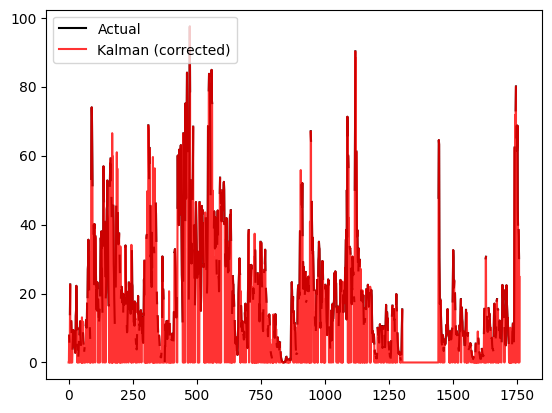

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 10ms/step - loss: 0.0034
Eƒüitim s√ºresi: 1.4554846286773682 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step 
Test s√ºresi: 0.12226009368896484 saniye
1736 1736
Train MAE: 4.94
Train Score: 7.86 RMSE
[[ 4.28]
 [ 4.  ]
 [ 2.82]
 ...
 [36.55]
 [30.28]
 [ 0.  ]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 9.921791188614765
test_RMSE: 14.40016182694297
test_msMAPE: 83.26924136819353
<function mean_imputation at 0x7f3ea33b8900>
1761


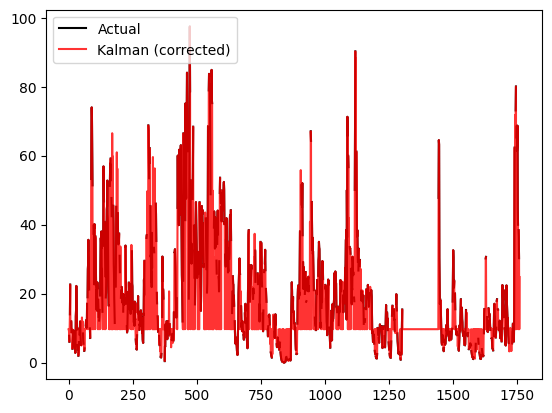

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 9ms/step - loss: 0.0031
Eƒüitim s√ºresi: 1.3773319721221924 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step 
Test s√ºresi: 0.12427878379821777 saniye
1736 1736
Train MAE: 4.62
Train Score: 7.07 RMSE
[[ 4.28     ]
 [ 4.       ]
 [ 2.82     ]
 ...
 [36.55     ]
 [30.28     ]
 [ 9.6912102]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 8.267074410860248
test_RMSE: 12.372797014677811
test_msMAPE: 46.76558068677515
<function median_imputation at 0x7f3ea33bb7e0>
1761


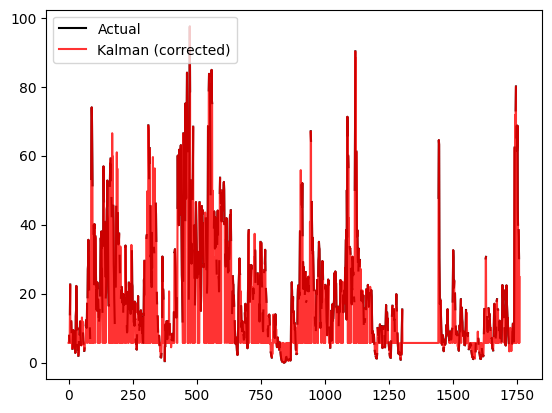

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 9ms/step - loss: 0.0030
Eƒüitim s√ºresi: 1.3855266571044922 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
Test s√ºresi: 0.13927340507507324 saniye
1736 1736
Train MAE: 4.30
Train Score: 7.23 RMSE
[[ 4.28]
 [ 4.  ]
 [ 2.82]
 ...
 [36.55]
 [30.28]
 [ 5.7 ]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 8.831935535891247
test_RMSE: 13.288597860399904
test_msMAPE: 53.765263528034005
<function forward_fill_imputation at 0x7f3ea33bbf60>
1761


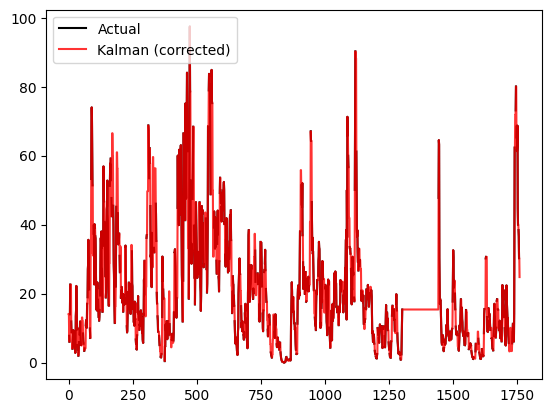

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 9ms/step - loss: 0.0023
Eƒüitim s√ºresi: 1.3694946765899658 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
Test s√ºresi: 0.12932491302490234 saniye
1736 1736
Train MAE: 3.19
Train Score: 5.64 RMSE
[[ 4.28]
 [ 4.  ]
 [ 2.82]
 ...
 [36.55]
 [30.28]
 [30.28]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 5.473654541223014
test_RMSE: 8.343356684482595
test_msMAPE: 32.10441257032874
<function backward_fill_imputation at 0x7f3ea33e4d60>
1761


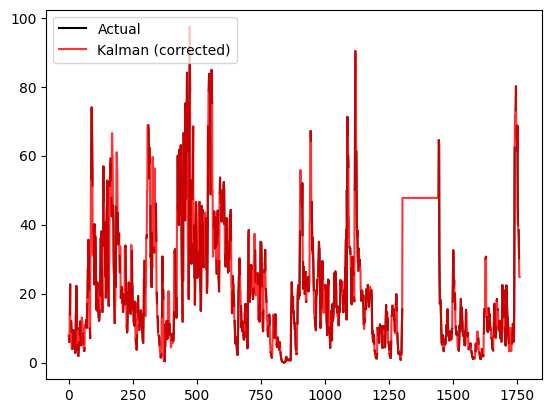

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 9ms/step - loss: 0.0028
Eƒüitim s√ºresi: 1.365121603012085 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
Test s√ºresi: 0.13120675086975098 saniye
1736 1736
Train MAE: 3.52
Train Score: 5.76 RMSE
[[ 4.28]
 [ 4.  ]
 [ 2.82]
 ...
 [36.55]
 [30.28]
 [24.8 ]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 5.93944551641505
test_RMSE: 8.614360157003638
test_msMAPE: 35.48504247225407
<function interpolation_imputation at 0x7f3ea33e4e00>
1761


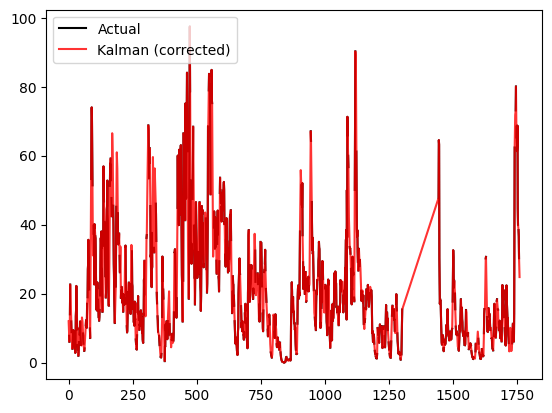

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 9ms/step - loss: 0.0019
Eƒüitim s√ºresi: 1.3557801246643066 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step  
Test s√ºresi: 0.12615180015563965 saniye
1736 1736
Train MAE: 3.30
Train Score: 5.43 RMSE
[[ 4.28]
 [ 4.  ]
 [ 2.82]
 ...
 [36.55]
 [30.28]
 [27.54]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 5.720698559720781
test_RMSE: 8.259823223238673
test_msMAPE: 34.00286004197969
<function kalman_filter_imputation at 0x7f3ea33e4ea0>
1761


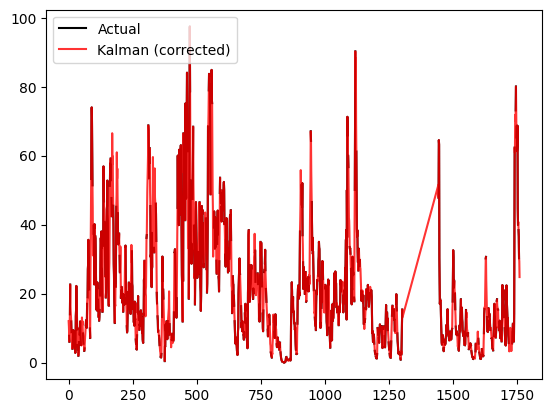

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 2s - 14ms/step - loss: 0.0029
Eƒüitim s√ºresi: 2.0768139362335205 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step 
Test s√ºresi: 0.11774396896362305 saniye
1736 1736
Train MAE: 3.51
Train Score: 5.75 RMSE
[[ 4.28      ]
 [ 4.        ]
 [ 2.82      ]
 ...
 [36.55      ]
 [30.28      ]
 [29.42688427]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 6.274027698799961
test_RMSE: 8.88596256804693
test_msMAPE: 36.12277277111946
<function svr_imputation_separate at 0x7f3ea33e4f40>
1761


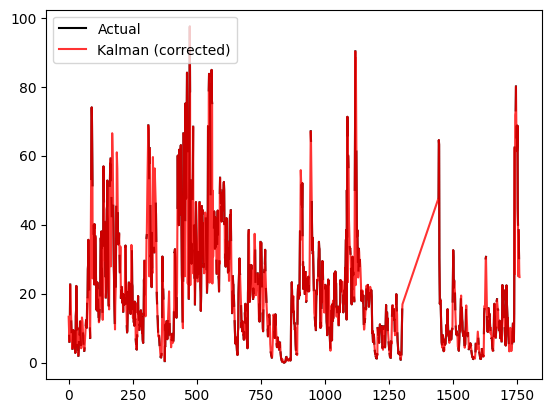

(7015, 24) (7015,)
(1736, 24) (1736,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 - 1s - 10ms/step - loss: 0.0022
Eƒüitim s√ºresi: 1.4007434844970703 saniye
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step  
Test s√ºresi: 0.12407207489013672 saniye
1736 1736
Train MAE: 3.45
Train Score: 5.77 RMSE
[[ 4.28      ]
 [ 4.        ]
 [ 2.82      ]
 ...
 [36.55      ]
 [30.28      ]
 [25.77975502]]
testPredict shape: (1736,)
orig_mask shape: (1736,)
Filtered TestY shape: (1214,)
Filtered TestPredict shape: (1214,)
test_MAE: 6.314050001749543
test_RMSE: 9.274682772733504
test_msMAPE: 36.60952448136998


In [ ]:
results=[]
results.append(["Dataset","Imputation method","Imputation Time (train+test)","Train MSE","Train MAE","Train RMSE","Train MAPE","Test MSE","Test MAE","Test RMSE","Test MAPE", "Test msMAPE"])


dataset_names_eskisehir=["VNS_Cumhuriyet_Bulvari.xlsx"]
'''
imputation_methods = [
        kalman_filter_imputation]
'''

"""dataset_names_eskisehir=["VNS_Odunpazari.xlsx",
               "VNS_Tepebasi.xlsx",
               "VNS_Visnepark.xlsx",
               "VNS_Metin_Sonmez.xlsx",
               "VNS_Cumhuriyet_Bulvari.xlsx"]"""


imputation_methods = [
        zero_imputation,
        mean_imputation,
        median_imputation,
        forward_fill_imputation,
        backward_fill_imputation,
        interpolation_imputation,
        kalman_filter_imputation,
        svr_imputation_separate]
'''

imputation_methods = [svr_imputation_separate]
'''

iter_results = {}
for name in dataset_names_eskisehir:
  #dataset_df=pd.read_csv("/content/drive/MyDrive/akademik √ßalƒ±≈ümalar/In progress/missing data in time series/VNS_dataset/"+name)
  #dataset_df=pd.read_excel("/content/drive/MyDrive/simulated_missing_xlsx/"+name)
  #dataset_df=pd.read_excel("/content/drive/MyDrive/VNS_dataset/VNS_Visnepark.xlsx")
  dataset_path = '/content/drive/MyDrive/eksik_veri_simulasyonlari/Odunpazari_missing_with_existing_25pct.xlsx'
  dataset_df = pd.read_excel(dataset_path, parse_dates=['Tarih'])
  dataset_df.replace("-",np.nan,inplace=True)
  dataset1 =  dataset_df.iloc[29530:]
  print(dataset_df.head())
  dataset1=dataset_df.iloc[:,1].to_numpy()
  data=dataset1
  print("data:", len(data))
  dates = dataset_df['Tarih'].copy()
  # NaN olmayan deƒüerleri filtrele
  #data = dataset[~np.isnan(dataset)]
  # ACF grafiƒüini √ßiz
  #plot_acf(data, lags=100)  # ƒ∞lk 100 gecikmeyi g√∂ster
  #plt.show()
    # √ñrneƒüin zaman serin


  # Subsample al
  #subsample, start_index = create_random_subsample(data, window_size, seed)
  #subsample_dates = dates[start_index:start_index + window_size]

  #data= subsample

  # %80 ve %20 oranlarƒ±nƒ± belirle
  split_index = int(len(data) * 0.8)
  # Eƒüitim (Train) ve Test b√∂l√ºmleri
  train_data = data[:split_index]  # ƒ∞lk %80
  test_data = data[split_index:]   # Son %20
  for method  in imputation_methods:
    start_imputation_time = time.time()
    print(method)
    imputed_train_full, imputed_test_full = method(np.copy(train_data), np.copy(test_data))

    # üîß Sadece test verisindeki NaN olan yerleri deƒüi≈ütir
    test_data_copy = np.copy(test_data)
    test_nan_mask = np.isnan(test_data_copy)
    final_test_imputed = np.copy(test_data_copy)
    final_test_imputed[test_nan_mask] = imputed_test_full[test_nan_mask]
    imputed_test = final_test_imputed  # Bundan sonra imputed_test kullanƒ±lacak

    train_data_copy = np.copy(train_data)
    train_nan_mask = np.isnan(train_data_copy)
    final_train_imputed = np.copy(train_data_copy)
    final_train_imputed[train_nan_mask] = imputed_train_full[train_nan_mask]
    imputed_train = final_train_imputed  # Bundan sonra imputed_train kullanƒ±lacak

    train_data
    print(len(imputed_test))
    plt.plot(test_data, color='black', label='Actual')
    plt.plot(imputed_test, color='red', alpha=0.8, label='Kalman (corrected)')
    plt.legend()
    plt.show()
    stop_imputation_time = time.time()

    if np.isnan(imputed_train).sum() > 0 or np.isnan(imputed_test).sum() > 0:
        print("there are missing values in data")
        break

    scaler = MinMaxScaler(feature_range=(0, 1))
    train = imputed_train.reshape(-1,1)
    train = scaler.fit_transform(train)
    test = scaler.transform(imputed_test.reshape(-1,1))
    look_back = 24
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    print(trainX.shape, trainY.shape)
    print(testX.shape, testY.shape)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    n_neurons = 30
    n_epoch = 1
    n_batch = 50

    train_start = time.time()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=n_epoch, batch_size=n_batch, verbose=2)
    train_end = time.time()
    train_time = train_end-train_start
    print(f"Eƒüitim s√ºresi: {train_time} saniye")
    trainPredict = model.predict(trainX)

    test_start = time.time()
    testPredict = model.predict(testX)
    test_end = time.time()
    test_time = test_end-test_start
    print(f"Test s√ºresi: {test_time} saniye")

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY.reshape(-1, 1))
    print(len(testY), len(testPredict))
    trainMAE = mean_absolute_error(trainY, trainPredict[:,0])
    trainMSE = np.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    train_rmse = np.sqrt(trainMSE)

    trainMAPE = mean_absolute_percentage_error(trainY, trainPredict[:,0])

    print('Train MAE: %.2f' % (trainMAE))
    print('Train Score: %.2f RMSE' % (trainMSE))

    orig_test = data[split_index+1:]  # Test kƒ±smƒ±nƒ±n orijinali
    orig_mask = ~np.isnan(orig_test)  # Eksik olmayanlar i√ßin maske
    valid_mask = orig_mask[look_back:]  # look_back sonrasƒ± ge√ßerli indeksler

    #valid_mask = orig_mask[look_back:]

    print(testY)

    testY = testY.flatten()
    testPredict = testPredict.flatten()

    print(f"testPredict shape: {testPredict.shape}")
    print(f"orig_mask shape: {valid_mask.shape}")
    # Maskeye g√∂re filtreleme
    filtered_testY = testY[valid_mask]
    filtered_testPredict = testPredict[valid_mask]

    print("Filtered TestY shape:", filtered_testY.shape)
    print("Filtered TestPredict shape:", filtered_testPredict.shape)

    if len(filtered_testY) == 0:
        print("Hata: Filtrelenmi≈ü test verileri bo≈ü.")
    else:
        testMAE = mean_absolute_error(filtered_testY, filtered_testPredict)
        testMSE = mean_squared_error(filtered_testY, filtered_testPredict)
        testMAPE = mean_absolute_percentage_error(filtered_testY, filtered_testPredict)
        testmsMAPE = modified_smape(filtered_testY, filtered_testPredict)
        test_rmse = np.sqrt(testMSE)
        print("test_MAE:", testMAE)
        print("test_RMSE:", test_rmse)
        print("test_msMAPE:", testmsMAPE)

    iter_results[f'Iter_True'] = filtered_testY
    iter_results[f'Iter_Pred'] = filtered_testPredict

    results.append([name,method,stop_imputation_time-start_imputation_time,trainMSE,trainMAE,train_rmse,trainMAPE,testMSE,testMAE,test_rmse,testMAPE, testmsMAPE])




pd.DataFrame(results).to_excel('OtherImputation_Odunpazari_25.xlsx')


max_length = max(len(values) for values in iter_results.values())
for key in iter_results:
    current_length = len(iter_results[key])
    if current_length < max_length:
        iter_results[key] = iter_results[key] + [np.nan] * (max_length - current_length)

# Artƒ±k t√ºm s√ºtunlarƒ±n uzunluƒüu e≈üit.
df_iter = pd.DataFrame({'Index': np.arange(max_length)})
for key, values in iter_results.items():
    df_iter[key] = values

# Son olarak, bu DataFrame'i CSV'ye yazdƒ±ralƒ±m.
#df_iter.to_excel(f'OtherImputation__LSTM_Iteration_Predictions_SideBySide_Tepebasi.xlsx', index=False)




